
# Text Classification with scikit-learn

This example shows how you can create a Hugging Face Hub compatible repo for a
text classification task using scikit-learn. We also show how you can generate
a model card for the model and the task at hand.


## Imports
First we will import everything required for the rest of this document.



In [1]:
import pickle
from pathlib import Path
from tempfile import mkdtemp, mkstemp

import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from skops import card

## Data
We will use 20 newsgroups dataset from sklearn. The dataset has curated
news on 20 topics. It has a training and a test split.



In [2]:
twenty_train = fetch_20newsgroups(subset="train", shuffle=True, random_state=42)

twenty_validation = fetch_20newsgroups(subset="test", shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    twenty_train.data, twenty_train.target, test_size=0.3, random_state=42
)

## Train a Model
To train a model, we need to convert our data first to vectors. We will use
CountVectorizer in our pipeline. We will fit a Multinomial
Naive Bayes model with the outputs of the vectorization.



In [3]:
model = Pipeline(
    [
        ("count", CountVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

model.fit(X_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('clf', MultinomialNB())])

## Inference
Let's see if the model works.



In [4]:
docs_new = [
    "A graphics processing unit is a specialized electronic circuit designed to"
    " manipulate and alter memory to accelerate the creation of images in a frame"
    " buffer intended for output to a display device.."
]
predicted = model.predict(docs_new)
print(twenty_train.target[predicted[0]])

4


## Initialize a repository to save our files in
We will now initialize a repository and save our model



In [5]:
#_, pkl_name = mkstemp(prefix="skops-", suffix=".pkl")

#with open(pkl_name, mode="bw") as f:
#    pickle.dump(model, file=f)

#local_repo = mkdtemp(prefix="skops-")

from datetime import datetime
import os

datestring = datetime.now().strftime("%Y%m%d%H")
local_repo = Path("../model-cards-examples") / datestring
local_repo.mkdir(exist_ok=True)

## Create a model card
We now create a model card. We will see below how we can populate the model
card with useful information.



In [6]:
model_card = card.Card(model)

## Add more information
So far, the model card does not tell viewers a lot about the model. Therefore,
we add more information about the model, like a description and what its
license is.



In [7]:
limitations = "This model is not ready to be used in production."
model_description = (
    "This is a Multinomial Naive Bayes model trained on 20 news groups dataset."
    "Count vectorizer is used for vectorization."
)
model_card_authors = "skops_user"
get_started_code = (
    "import pickle\nwith open(pkl_filename, 'rb') as file:\n    clf = pickle.load(file)"
)
citation_bibtex = "bibtex\n@inproceedings{...,year={2020}}"
model_card.add(
    citation_bibtex=citation_bibtex,
    get_started_code=get_started_code,
    model_card_authors=model_card_authors,
    limitations=limitations,
    model_description=model_description,
)

Card(
  model=Pipeline(steps=[('count', CountVectorizer()), ('clf', MultinomialNB())]),
  Model description/Training Procedure/Hyperparameters=TableSection(26x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  citation_bibtex=bibtex @inproceedings{...,year={2020}},
  get_started_code=import pickle with open(pkl_f...file: clf = pickle.load(file),
  model_card_authors=skops_user,
  limitations=This model is not ready to be used in production.,
  model_description=This is a Multinomial Naive ...er is used for vectorization.,
)

## Add plots, metrics, and tables to our model card
We will now evaluate our model and add our findings to the model card.



Card(
  model=Pipeline(steps=[('count', CountVectorizer()), ('clf', MultinomialNB())]),
  Model description/Training Procedure/Hyperparameters=TableSection(26x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Evaluation Results=TableSection(2x2),
  citation_bibtex=bibtex @inproceedings{...,year={2020}},
  get_started_code=import pickle with open(pkl_f...file: clf = pickle.load(file),
  model_card_authors=skops_user,
  limitations=This model is not ready to be used in production.,
  model_description=This is a Multinomial Naive ...er is used for vectorization.,
  eval_method=The model is evaluated on valid...and F1-score with micro average.,
  Confusion matrix=PlotSection(confusion_matrix.png),
  Classification Report=TableSection(22x5),
)

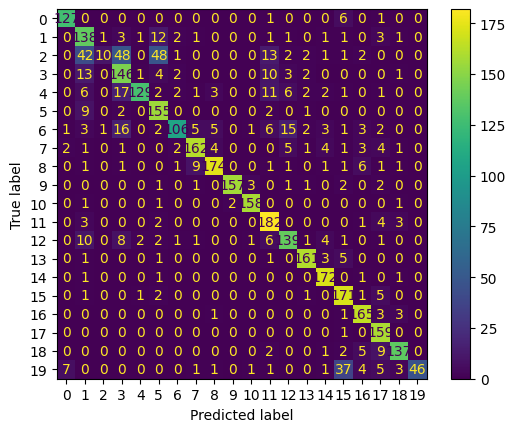

In [8]:
y_pred = model.predict(X_test)
eval_descr = (
    "The model is evaluated on validation data from 20 news group's test split,"
    " using accuracy and F1-score with micro average."
)
model_card.add(eval_method=eval_descr)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="micro")
model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1})

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
model_card.add_plot(**{"Confusion matrix": "confusion_matrix.png"})

clf_report = classification_report(
    y_test, y_pred, output_dict=True, target_names=twenty_train.target_names
)
# The classification report has to be transformed into a DataFrame first to have
# the correct format. This requires removing the "accuracy", which was added
# above anyway.
del clf_report["accuracy"]
clf_report = pd.DataFrame(clf_report).T.reset_index()
model_card.add_table(
    folded=True,
    **{
        "Classification Report": clf_report,
    },
)

## Save model card
We can simply save our model card by providing a path to :meth:`.Card.save`.
The model hasn't been pushed to Hugging Face Hub yet, if you want to see how
to push your models please refer to
`this example <sphx_glr_auto_examples_plot_hf_hub.py>`.



In [9]:
model_card.save(Path(local_repo) / "README_plot_text_classification.md")